In [1]:
import pandas as pd
from operator import attrgetter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
def load_and_clean_data(filepath:str) -> pd.DataFrame:
    """
    Функция загружает данные из CSV, выполняет очистку: удаляет NaN, дубликаты, аномалии.
    
    Параметры:
    ----------
    filepath : str
        Путь к CSV-файлу с данными.

    Возвращает:
    ----------
    pd.DataFrame
        Очищенный DataFrame с корректными значениями.
    """
    try:
        df = pd.read_csv(filepath, encoding='unicode_escape')

        # Убираем строки с отсутствующими значениями
        df.dropna(subset=['Customer ID', 'InvoiceDate'], inplace=True)
        df.drop_duplicates(inplace=True)

        # Преобразуем дату и фильтруем данные
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

        # Фильтруем отрицательные значения
        df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

        df.info()

        return df

    except pd.errors.ParserError:
        print("Ошибка: Неверный формат CSV-файла. Проверь разделители и кодировку.")
        return None 

    except FileNotFoundError:
        print("Ошибка: Файл не найден. Проверь путь к файлу.")
        return None

In [3]:
df = load_and_clean_data("2010_2011.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 392693 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      392693 non-null  object        
 1   StockCode    392693 non-null  object        
 2   Description  392693 non-null  object        
 3   Quantity     392693 non-null  int64         
 4   InvoiceDate  392693 non-null  datetime64[ns]
 5   Price        392693 non-null  float64       
 6   Customer ID  392693 non-null  float64       
 7   Country      392693 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB


In [4]:
def create_cohort_data(df:pd.DataFrame) -> pd.DataFrame:
    """
    Создает когортные данные: определяет первый заказ клиента и формирует когортный анализ.
    
    Параметры:
    ----------
    df : pd.DataFrame
        DataFrame с очищенными данными о заказах.

    Возвращает:
    ----------
    pd.DataFrame
        Когортные данные с числом клиентов по месяцам.
    """
    # Создаем столбец с месяцем заказа
    df['order_month'] = df['InvoiceDate'].dt.to_period('M')

    # Определяем первый заказ каждого клиента
    df['cohort_month'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

    # Группируем по когортам
    cohort_data = df.groupby(['cohort_month', 'order_month']).agg(n_customers=('Customer ID', 'nunique')).reset_index()

    # Добавляем номер периода (разница между месяцами)
    cohort_data['period_number'] = (cohort_data.order_month - cohort_data.cohort_month).apply(lambda x: x.n)

    return cohort_data

In [5]:
cohort_data = create_cohort_data(df)

In [6]:
def create_retention_matrix(cohort_data:pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """
    Строит матрицу удержания на основе когортных данных.
    
    Параметры:
    ----------
    cohort_data : pd.DataFrame
        DataFrame с когортными данными, содержащий `cohort_month`, `order_month` и `n_customers`.

    Возвращает:
    ----------
    tuple[pd.DataFrame, pd.Series]
        - retention_matrix: Матрица удержания (значения от 0 до 1).
        - cohort_size: Размер каждой когорты (количество клиентов в первый месяц).
    """
    # Создаем сводную таблицу
    cohort_pivot = cohort_data.pivot_table(index='cohort_month', columns='period_number', values='n_customers')
    
    # Размер когорты (первый столбец)
    cohort_size = cohort_pivot.iloc[:, 0]
    
    # Вычисляем коэффициент удержания (retention rate)
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    
    return retention_matrix, cohort_size

In [7]:
retention_matrix, cohort_size = create_retention_matrix(cohort_data)

In [8]:
def plot_cohort_analysis(retention_matrix:pd.DataFrame, cohort_size:pd.Series) -> None:
    """
    Визуализирует когортный анализ: тепловые карты размера когорт и коэффициента удержания.
    """

    fig, ax = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [0.5, 4]}) 
    
    # График размера когорт 
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Cohort Size'})
    cohort_size_df.index.name = None 

    sns.heatmap(
        cohort_size_df, 
        annot=True, fmt='g', cmap=mcolors.ListedColormap(['white']), 
        cbar=False, ax=ax[0], linewidths=0.1
    )
    ax[0].set_title('Cohort Size', fontsize=10, pad=10)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('')

    # График удержания
    retention_matrix = retention_matrix.reset_index(drop=True)  

    sns.heatmap(
        retention_matrix, 
        mask=retention_matrix.isnull(), 
        annot=True, fmt='.0%', cmap='RdYlGn', 
        ax=ax[1], yticklabels=False, linewidths=0.1
    )
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=12, pad=10)
    ax[1].set_xlabel('Number of periods')
    ax[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

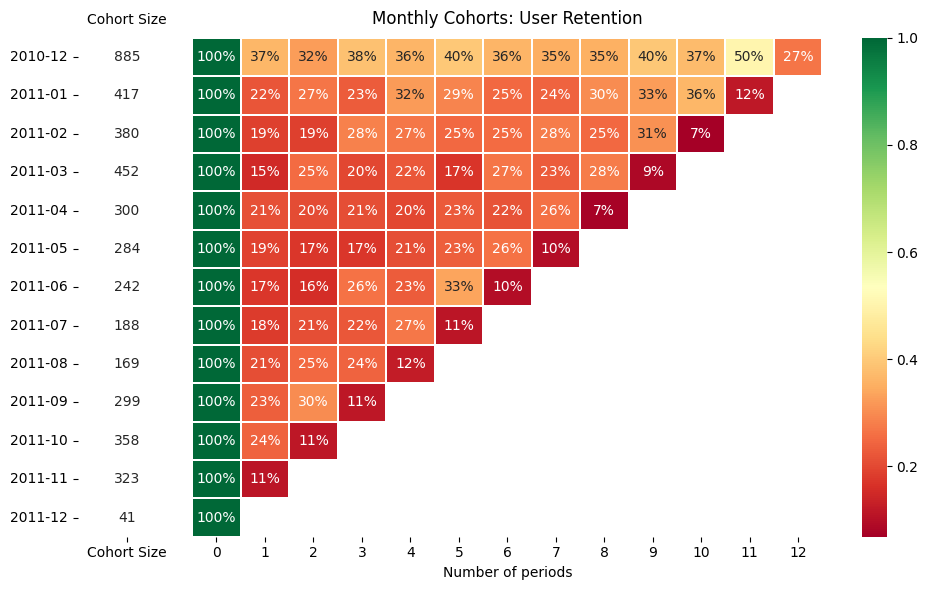

In [9]:
plot_cohort_analysis(retention_matrix, cohort_size)

**Итоги:**

**1. Удержание клиентов быстро падает**

Во всех когортных рядах наблюдается резкое падение после 1-го месяца.

Типичная проблема в e-commerce: клиенты пробуют сервис, но не возвращаются повторно.

✅ Анализировать, почему клиенты уходят.

✅ Добавить welcome-кампании, скидки, напоминания.

**2. Удержание стабилизируется, но на низком уровне**

После 3-4 месяцев удержание замедляется (примерно на уровне 10-30%).

Это значит, что часть клиентов остается, но большинство уходит.

✅ Работать над повторными покупками (рассылки, предложения, программы лояльности).

✅ Анализировать поведение удержавшихся клиентов и на основе их активности подстраивать маркетинг.

**3. Некоторые когорты показывают аномальные скачки**

В когорте 2011-06 на 5-м месяце удержание поднимается до 33% (выше, чем у соседних когорт).

Возможно, была акция, скидки, маркетинговая активность.

Это можно использовать как успешный кейс.

✅ Проверить маркетинговые активности в этот период.

✅ Повторить успешную стратегию на другие когорты.

**4. Некоторые когорты показывают более слабые результаты**

Это может быть связано с низким качеством продукта, сезонностью или плохой маркетинговой стратегией.

✅ Проверить, почему эти клиенты уходят быстрее (анализ отзывов, обратная связь).

✅ Сравнить с успешными когортами и понять разницу.